<a href="https://colab.research.google.com/github/suyash-s09/Pravega-Workshop/blob/main/Pravega_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing for Kushal


# Automated Dataset Generation with Grounding DINO + Segment Anything Model (SAM)

---

In this tutorial, you will learn how to automatically annotate your images using two groundbreaking models - [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) and [Segment Anything Model (SAM)](https://github.com/facebookresearch/segment-anything). You can then use this dataset to train a real-time object detection or instance segmentation model. Annotation of images using polygons in the traditional way is extremely time-consuming and expensive. With Grounding DINO and SAM, initial annotation takes only a few minutes and your work is reduced to manual verification of obtained labels.

![auto-annotation-with-grounded-sam](https://media.roboflow.com/notebooks/examples/auto-annotation-with-grounded-sam.png)

*Figure showing the effects of automatic annotation. The raw image on the left; Object detection annotations obtained with Grounding DINO in the middle; Instance segmentation annotations obtained with Grounding DINO + SAM on the right.*

## Complementary Materials

---

Want to learn more? 🤓 We have prepared separate tutorials where you can learn how to use Grounding DINO and Segment Anything Model (SAM). You will find all the necessary links below.

- Segment Anything Model

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything) [![arXiv](https://img.shields.io/badge/arXiv-2304.02643-b31b1b.svg)](https://arxiv.org/abs/2304.02643) [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb) [![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/D-D6ZmadzPE) [![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-use-segment-anything-model-sam)

- Grounding DINO

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/IDEA-Research/GroundingDINO) [![arXiv](https://img.shields.io/badge/arXiv-2303.05499-b31b1b.svg)](https://arxiv.org/abs/2303.05499) [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-with-grounding-dino.ipynb) [![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/cMa77r3YrDk) [![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/grounding-dino-zero-shot-object-detection)

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install Grounding DINO and Segment Anything Model
- Load models
- Download Example Data
- Single Image Mask Auto Annotation

## Let's begin! 🔥

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Tue Jan 23 13:59:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Grounding DINO and Segment Anything Model

Our project will use two groundbreaking designs - [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) - for zero-shot detection and [Segment Anything Model (SAM)](https://github.com/facebookresearch/segment-anything) - for converting boxes into segmentations. We have to install them first.


In [ ]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 421 (delta 138), reused 132 (delta 125), pack-reused 237
Receiving objects: 100% (421/421), 12.85 MiB | 28.06 MiB/s, done.
Resolving deltas: 100% (215/215), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.8 MB/s eta 0:00:00


In [ ]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-6fzt9ggf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-6fzt9ggf
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=22ac105bf46d2c591cfe5d62d4aa4d8421a4933c9bd37e97325bc44017699354
  Stored in directory: /tmp/pip-ephem-wheel-cache-p86ctt17/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


**NOTE:** To glue all the elements of our demo together we will use the [`supervision`](https://github.com/roboflow/supervision) pip package, which will help us **process, filter and visualize our detections as well as to save our dataset**. A lower version of the `supervision` was installed with Grounding DINO. However, in this demo we need the functionality introduced in the latest versions. Therefore, we uninstall the current `supervsion` version and install version `0.6.0`.



In [ ]:
!pip uninstall -y supervision
!pip install -q supervision==0.6.0
!pip install -qq -U diffusers==0.11.1 transformers ftfy accelerate

import supervision as sv
print(sv.__version__)

Found existing installation: supervision 0.4.0
Uninstalling supervision-0.4.0:
  Successfully uninstalled supervision-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 32.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatib

### Download Grounding DINO Model Weights

To run Grounding DINO we need two files - configuration and model weights. The configuration file is part of the [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) repository, which we have already cloned. The weights file, on the other hand, we need to download. We write the paths to both files to the `GROUNDING_DINO_CONFIG_PATH` and `GROUNDING_DINO_CHECKPOINT_PATH` variables and verify if the paths are correct and the files exist on disk.

In [ ]:
import os

GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [ ]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [ ]:
import os

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


### Download Segment Anything Model (SAM) Weights

As with Grounding DINO, in order to run SAM we need a weights file, which we must first download. We write the path to local weight file to `SAM_CHECKPOINT_PATH` variable and verify if the path is correct and the file exist on disk.

In [ ]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [ ]:
import os

SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Load models

In [ ]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Grounding DINO Model

In [ ]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/content/GroundingDINO


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### Load Segment Anything Model (SAM)

In [ ]:
SAM_ENCODER_VERSION = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

## Creating Directory to store the data & the mask required for inpainting

The images are stored in - content/data/images
<br>
The mask are stored in - content/data/mask
<br>
<br>

*If you want to capture another image rerun the cells from below*



In [ ]:
f"{HOME}/drive/MyDrive/data"

'/content/drive/MyDrive/data'

In [ ]:
%cd {HOME}/drive/MyDrive
!mkdir {HOME}/drive/MyDrive/data
%cd {HOME}/drive/MyDrive/data
!mkdir images
%cd images


/content/drive/MyDrive
/content/drive/MyDrive/data
/content/drive/MyDrive/data/images


## Take input from WebCam

Before taking input empty the folder

In [ ]:
#removing the photo
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!rm photo.jpg

rm: cannot remove 'photo.jpg': No such file or directory


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

## Saving the webcam image in content/data as photo.jpg

<IPython.core.display.Javascript object>

Saved to photo.jpg


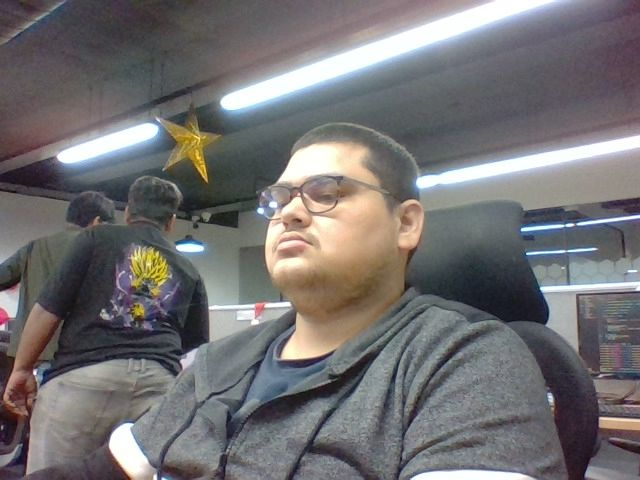

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()

  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Single Image Mask Auto Annotation

Before we automatically annotate the entire dataset let's focus for a moment on a single image.

In [ ]:
SOURCE_IMAGE_PATH = f"{HOME}/drive/MyDrive/data/images/photo.jpg"
CLASSES = ['undefined','car', 'dog','man', 'person', 'ear','nose','eye','hand','chair', 'shoe']
# CLASSES = ['undefined']
# n = int(input("Enter the number of classes you want for segmentation: "))
# for i in range(n):
#   seg_class = input("ENter the classname for segmentation: ")
#   CLASSES.append(seg_class)

BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25
print(CLASSES)

['undefined', 'car', 'dog', 'man', 'person', 'ear', 'nose', 'eye', 'hand', 'chair', 'shoe']


### Zero-Shot Object Detection with Grounding DINO

**NOTE:** To get better Grounding DINO detection we will leverage a bit of prompt engineering using `enhance_class_name` function defined below. 👇 You can learn more from our [Grounding DINO tutorial](https://blog.roboflow.com/grounding-dino-zero-shot-object-detection/).

In [ ]:
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

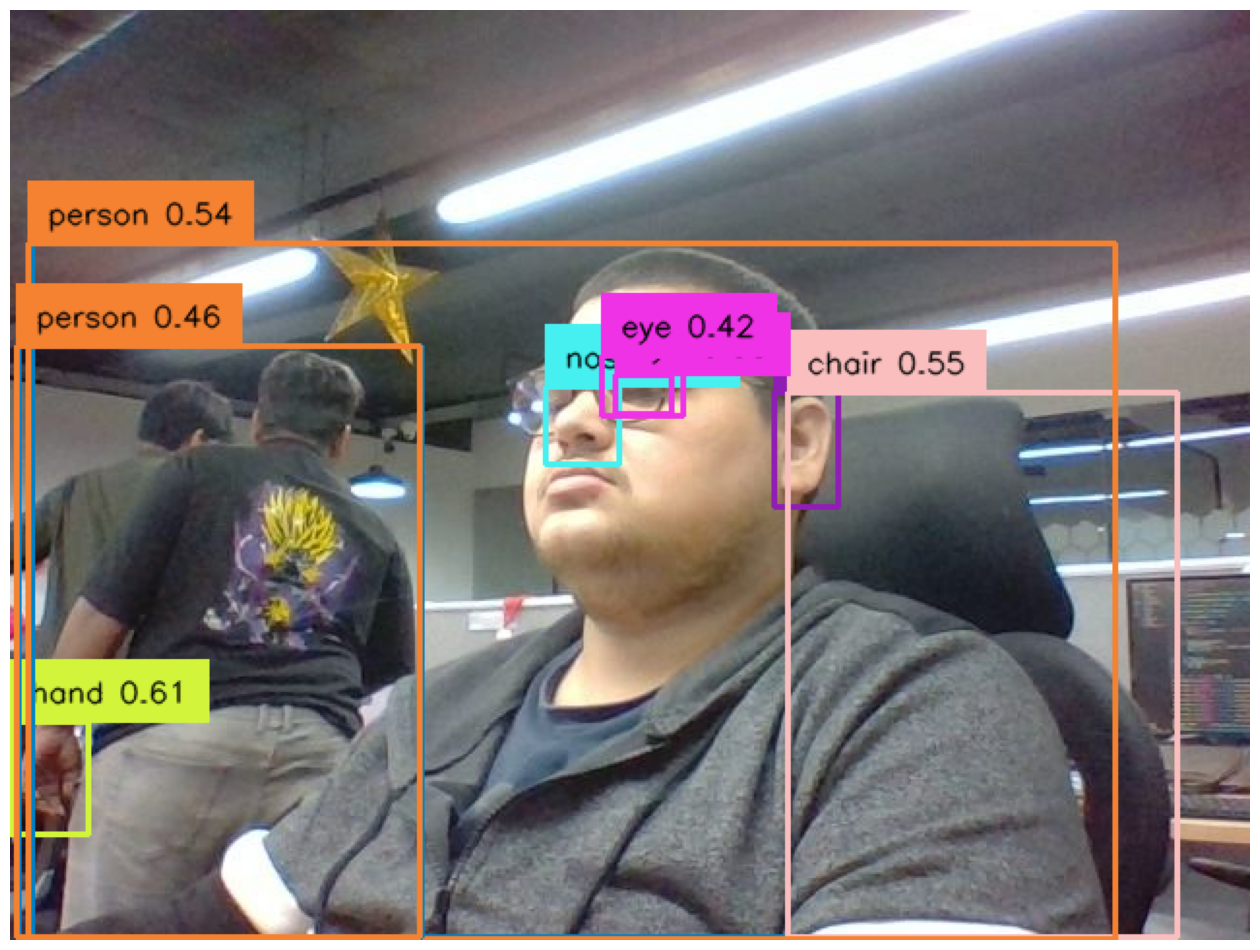

In [ ]:
import cv2
import supervision as sv

# load image
image = cv2.imread(SOURCE_IMAGE_PATH)

# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)
for i in range(len(detections.class_id)):
    if detections.class_id[i] is None:
        detections.class_id[i] = 0
    #print(CLASSES[i])
# annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

### Prompting SAM with detected boxes

In [ ]:
import numpy as np
from segment_anything import SamPredictor


def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

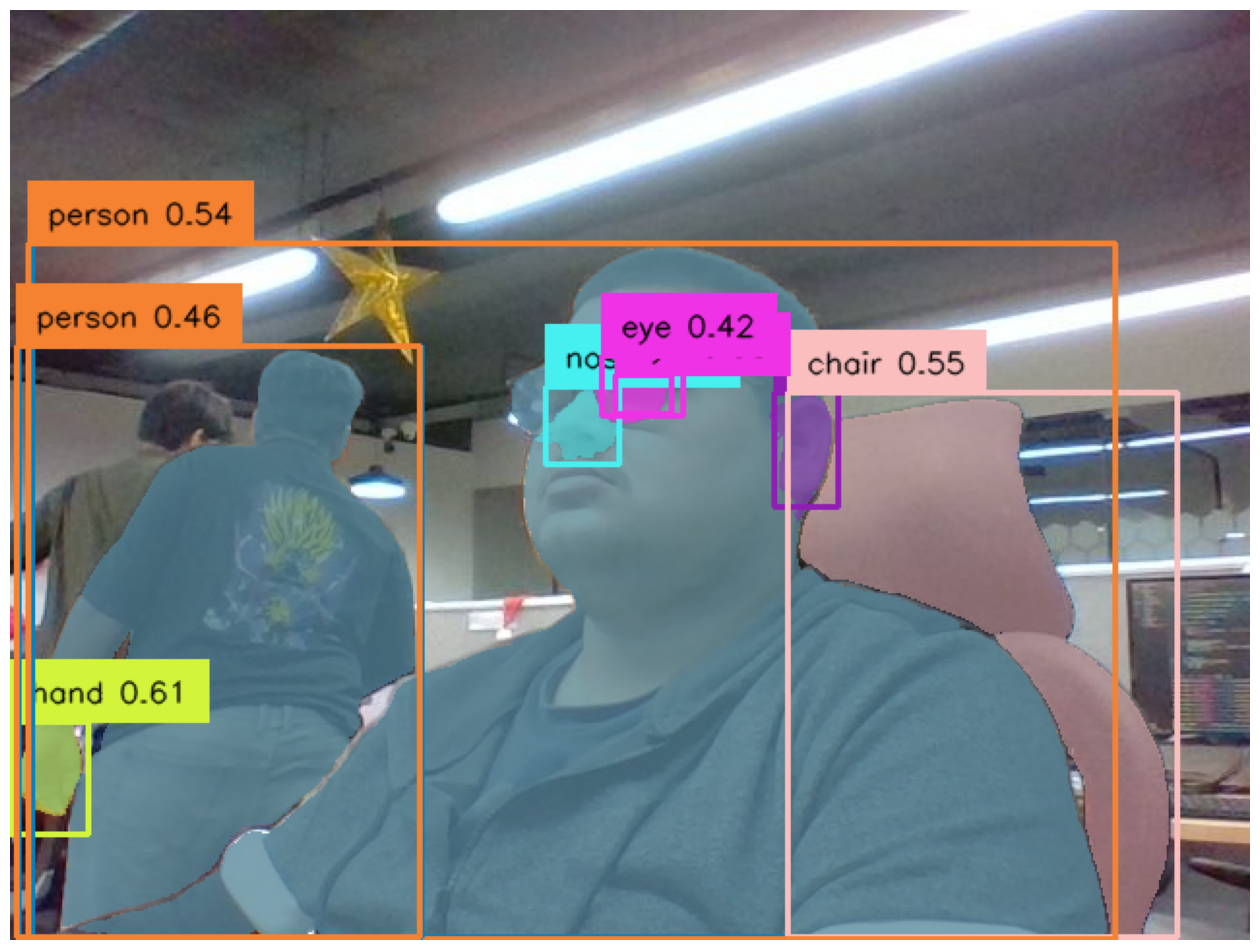

In [ ]:
import cv2

# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))


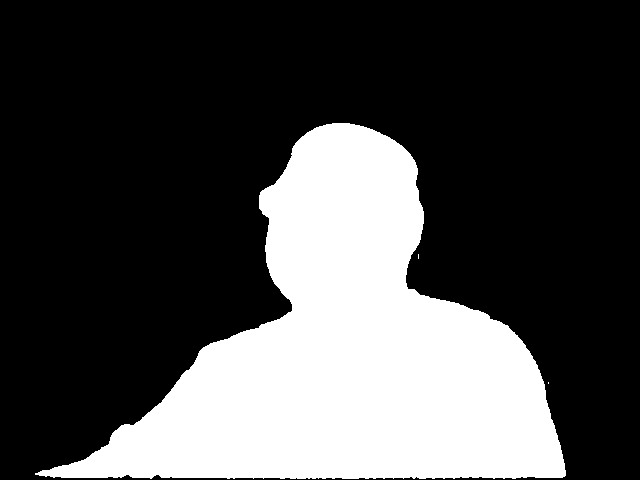

0.619118


In [ ]:
import os
import math
from PIL import Image
from IPython.display import display

mask_folder_path = '/content/drive/MyDrive/data/masks/'
grid_size_dimension = math.ceil(math.sqrt(len(detections.mask)))
os.makedirs(mask_folder_path, exist_ok=True)

titles = [CLASSES[class_id] for class_id in detections.class_id]
personDetected  = False
maxConfidence = 0
image_filename = ""
# Plot and save images
for i, (image, title) in enumerate(zip(detections.mask, titles)):
    # Create a Pillow image from the NumPy array

    if(title=='person' or title=='man' or title=='woman'):

      #print(f"{title}: {detections.confidence[i]} {maxConfidence}")

      if(detections.confidence[i]>maxConfidence):
        pillow_image = Image.fromarray((image * 255).astype('uint8'))

        # Display the image in Colab
        display(pillow_image)
        maxConfidence = detections.confidence[i]
        print(maxConfidence)
        # Save the image in the 'mask' folder
        image_filename = f"{mask_folder_path}photo_mask.png"
        personDetected = True
pillow_image.save(image_filename, dpi=(1200, 1200))


if(personDetected==False):
  print("Person is not detected , take image again.")


## InPainting

Stable Diffusion Inpainting is a latent text-to-image diffusion model capable of generating photo-realistic images given any text input, with the extra capability of inpainting the pictures by using a mask.

The Stable-Diffusion-Inpainting was initialized with the weights of the Stable-Diffusion-v-1-2. First 595k steps regular training, then 440k steps of inpainting training at resolution 512x512 on “laion-aesthetics v2 5+” and 10% dropping of the text-conditioning to improve classifier-free classifier-free guidance sampling.

![txt2img-stable2](https://raw.githubusercontent.com/runwayml/stable-diffusion/main/assets/stable-inpainting/merged-bench.png)

### Installing all the necessary libraries

In [ ]:
# !pip uninstall -y supervision
# !pip install -q supervision==0.4.0
!pip install -qq -U diffusers==0.11.1 transformers ftfy accelerate

### Importing all the necessary libraries

In [ ]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch
import os
from transformers.utils import *

import PIL
from diffusers import StableDiffusionInpaintPipeline

### Declare Path Variables

In [ ]:
PROMPT_IMG_DIR = "/content/drive/MyDrive/data/prompt_images"
IMG_DIR = "/content/drive/MyDrive/data/images"
MASK_DIR = "/content/drive/MyDrive/data/masks"

### Helper functions to load and display the images

In [ ]:
def load_image(path):
    return PIL.Image.open(path).convert("RGB")

def invert_image(img):
    img = PIL.ImageOps.invert(img)
    return img

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def save_images(imgs, prompt):
    if os.path.isdir(f"{PROMPT_IMG_DIR}/{prompt}") == False:
      os.mkdir(f"{PROMPT_IMG_DIR}/{prompt}")
    for i in range(len(imgs)):
        imgs[i].save(f"{PROMPT_IMG_DIR}/{prompt}/{prompt}_{i+1}.png")

def delete_prompt_dir(prompt):
    if os.path.isdir(f"{PROMPT_IMG_DIR}/{prompt}") == True:
      !rm -r "{PROMPT_IMG_DIR}/{prompt}"

### Load the pretrained Stable-Diffusion-Inpainting model and integrate it to run in CUDA

In [ ]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

text_encoder/model.safetensors not found


Fetching 24 files:   0%|          | 0/24 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

### Define image and mask path

In [ ]:
image_path = f"{IMG_DIR}/photo.jpg"
mask_path = f"{MASK_DIR}/photo_mask.png"

### Loading and Resizing Original and Masked Image

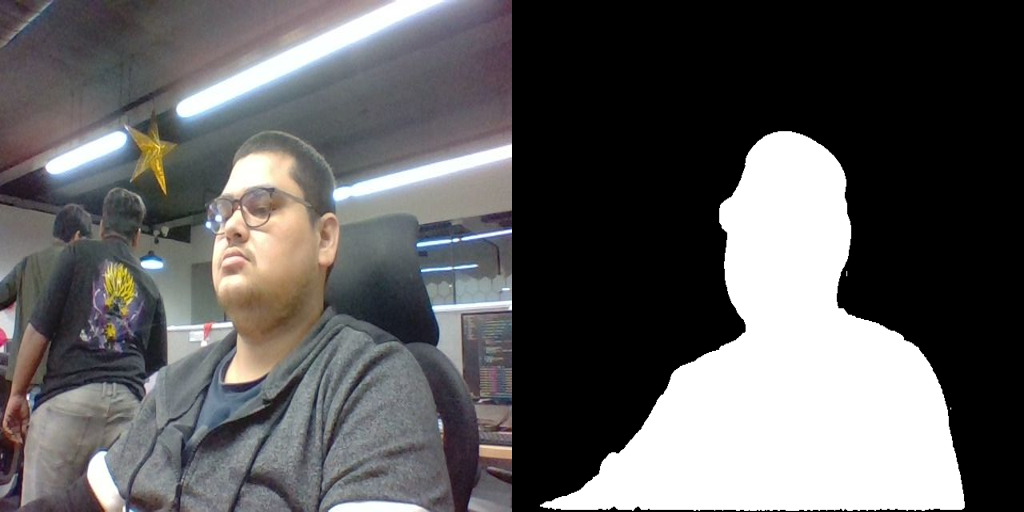

In [ ]:
image = load_image(image_path).resize((512,512))
mask_image = load_image(mask_path).convert('L').resize((512,512))
image_grid([image, mask_image], 1, 2)

### Initializing the input parameters for the model

In [ ]:
inpaint_prompt =input("Enter a prompt: ") # prompt to inpaint the segmented part
guidance_scale = 7.5 # encourages the model to generate images closely linked to the text prompt (default = 7.5)
num_samples = 3 # number of samples to be generated
generator = torch.Generator(device="cuda") # generate using which device cpu/gpu
generator = generator.manual_seed(10) # change the seed to get different results

Enter a prompt: Dalai Lama


### Generating images using the above parameters

In [ ]:
prompt_images = pipeline(
    prompt = inpaint_prompt,
    image = image,
    mask_image = mask_image,
    guidance_scale = guidance_scale,
    generator = generator,
    num_images_per_prompt = num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

### Display the prompt images

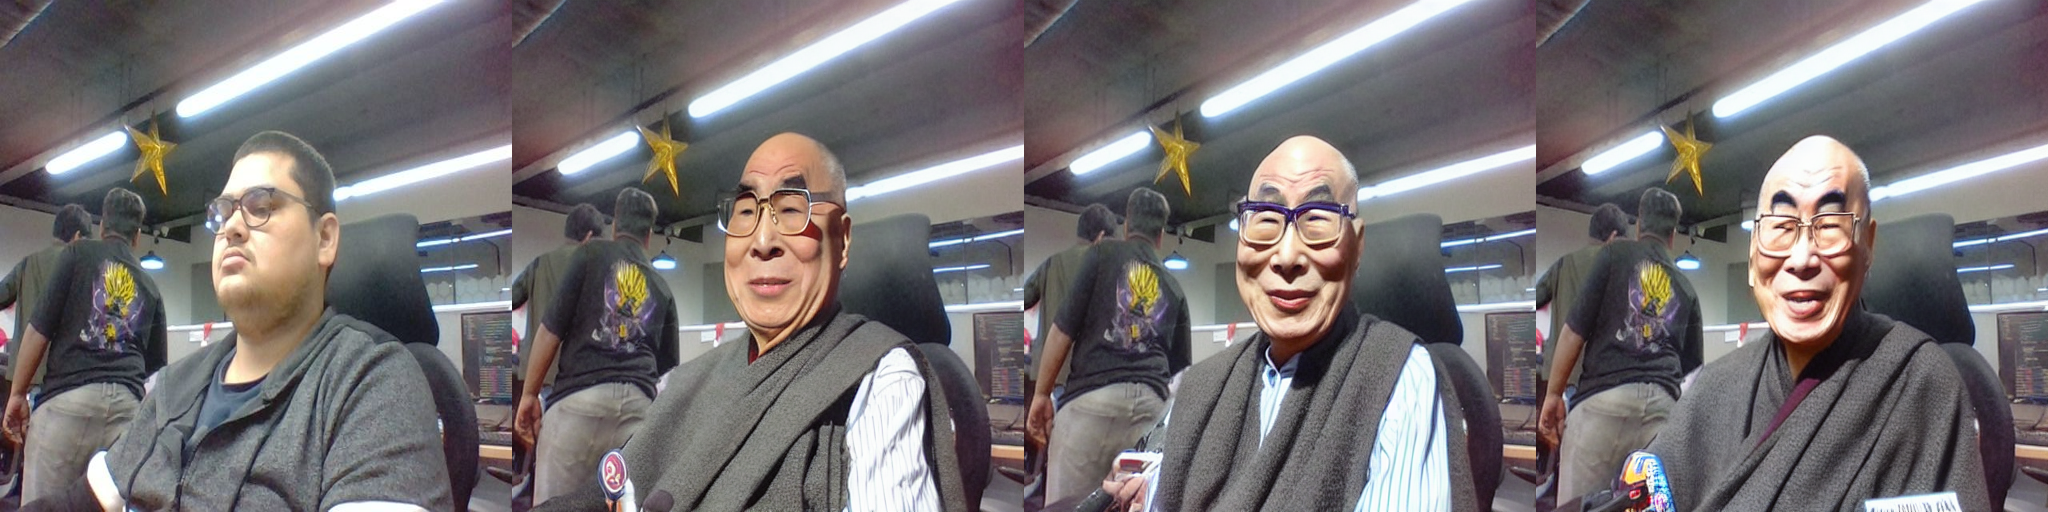

In [ ]:
prompt_images.insert(0, image) # insert initial image in the list so we can compare side by side
image_grid(prompt_images, 1, num_samples + 1)

### Save the images

In [ ]:
save_prompt = input("To save the images press y: ")
if save_prompt == "y":
    save_images(prompt_images, inpaint_prompt) # saves images with naming convention {prompt}_{image_index}.png

### Now what if you want change the background of the image, not the person?

### Inverting the image to choose background to be inpainted

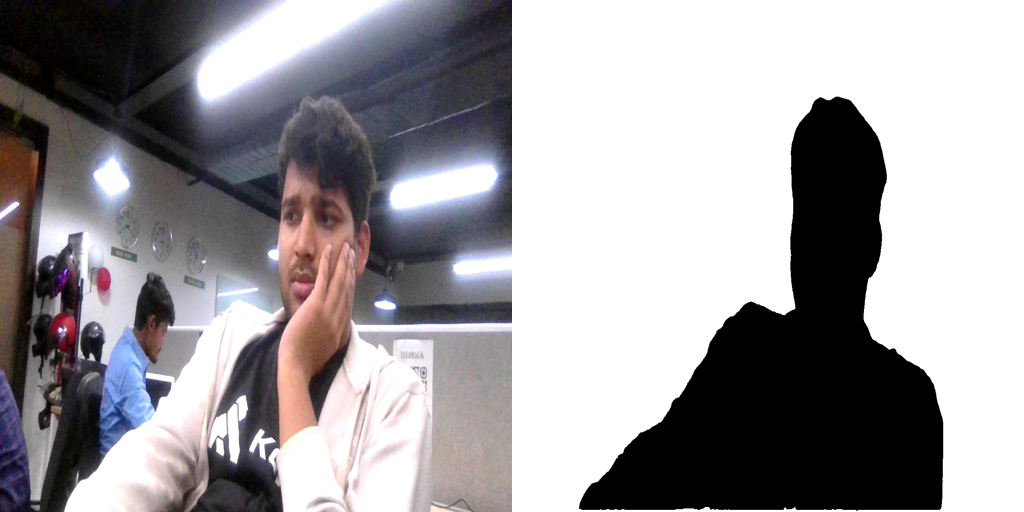

In [ ]:
mask_image = invert_image(mask_image)
image_grid([image, mask_image], 1, 2)

### Initializing the input parameters for the model

In [ ]:
inpaint_prompt = input("Enter a prompt: ") # prompt to inpaint the segmented part
guidance_scale = 7.5 # encourages the model to generate images closely linked to the text prompt (default = 7.5)
num_samples = 3 # number of samples to be generated
generator = torch.Generator(device="cuda") # generate using which device cpu/gpu
generator = generator.manual_seed(0) # change the seed to get different results

Enter a prompt: Opera


### Generating images using the above parameters

In [ ]:
prompt_images = pipeline(
    prompt = inpaint_prompt,
    image = image,
    mask_image = mask_image,
    guidance_scale = guidance_scale,
    generator = generator,
    num_images_per_prompt = num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

### Display the prompt images

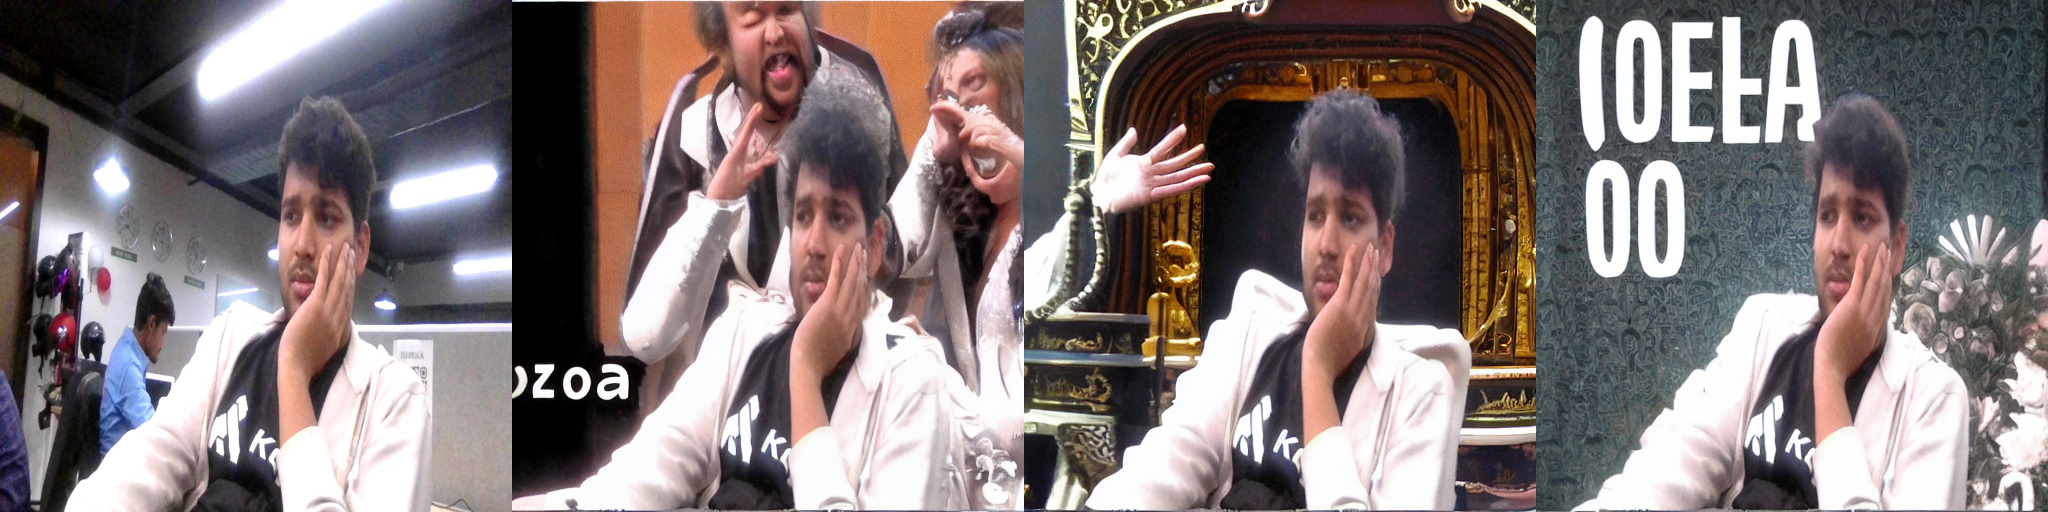

In [ ]:
prompt_images.insert(0, image) # insert initial image in the list so we can compare side by side
image_grid(prompt_images, 1, num_samples + 1)

### Save the images

In [ ]:
save_prompt = input("To save the images press y: ")
if save_prompt == "y":
    print("Images saved successfully...")
    save_images(prompt_images, inpaint_prompt) # saves images with naming convention {prompt}_{image_index}.png

To save the images press y: n
